**Загрузка пакетов**

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import optimize 
import subprocess
import numpy as np
import math

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem import Draw
from IPython.display import display,Image

**Задача** -> Определение констант ковалентных взаимодействий для молекулярной механики этана на основе квантово-химических расчётов

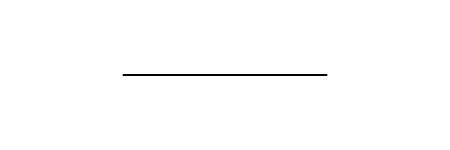

In [7]:
etan=Chem.MolFromSmiles('CC')
AllChem.Compute2DCoords(etan)
display(etan)

In [ ]:
# Имеем на входе оптимизированную структуру этана:

inp = '''!HF RHF 6-31G
* int 0 1
C 0 0 0 0 0 0 
C 1 0 0 1.52986 0 0 
H 1 2 0 1.08439 111.200 0
H 1 2 3 1.08439 111.200 120
H 1 2 3 1.08439 111.200 -120
H 2 1 3 1.08439 111.200 180
H 2 1 5 1.08439 111.200 120
H 2 1 5 1.08439 111.200 -120
*
'''

# Из кода на "птичьем" языке видим, что расчет оптимальной структуры был сделан так, 
# что для внутренних электронов использовались 6 гауссианов с фиксированными коэффициентами,
# для "внешних", валентных, электронов, участвующих в ковалентных взаимодействиях, коэффициенты в 3 гауссианах фиксированы,
# в 1 гауссиане - вариабельные и оптимизировались.

# В Z-matrix:
# 5 колонка - длина связи
# 6 колонка - валентный угол
# 7 колонка - торсионный угол

Функция для генерации файлов для ORCA (.inp):

In [36]:
def inp_len(length):
    inp = '''!HF RHF 6-31G
    * int 0 1
    C 0 0 0 0 0 0 
    C 1 0 0 {} 0 0 
    H 1 2 0 1.08439 111.200 0
    H 1 2 3 1.08439 111.200 120
    H 1 2 3 1.08439 111.200 -120
    H 2 1 3 1.08439 111.200 180
    H 2 1 5 1.08439 111.200 120
    H 2 1 5 1.08439 111.200 -120
    *
    '''.format(length)
    return inp

Функция по запуску ORCA:

In [10]:
def run_orca(inp):
    with open('orca.inp', 'w') as outfile:
        outfile.write(inp)
    p = subprocess.Popen("/home/shad/progs/bin/orca orca.inp", 
                          shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out=p.communicate()[0]
    
    # extract energy: FINAL SINGLE POINT ENERGY'
    for i in out.splitlines():
        if i.startswith("FINAL SINGLE POINT ENERGY"):
            return(float(i[len("FINAL SINGLE POINT ENERGY"):]))
    # and return it as float
    return out.splitlines()

Зависимость энергии молекулы от длины одной связи:

In [41]:
def energy_dependency(x,y,title,lim1,lim2):
    # fake x array , replace with real one
    x_o=x
    # fake y array, replace with energies
    y_o=y

    #function is  f(x)=k(b-x)^2 + a
    fitfunc = lambda p, x: p[0]*pow(p[1]-x,2) + p[2] # Target function
    errfunc = lambda p, x, y: fitfunc(p, x) - y # Error function

    p0 = [1,1, -79] # Initial guess for the parameters
    p1, success = optimize.leastsq(errfunc, p0[:], args=(x_o, y_o))
    print "Optimized params:", p1

    #Plot it
    plt.plot(x_o, y_o, "ro", x_o,fitfunc(p1,x_o),"r-",c='blue',alpha=0.5)
    plt.xlim(lim1,lim2)
    plt.title(title)
    plt.show()

**Формируем массив 20 различных длинн связи с шагом в 0.02 ангстрем**

In [34]:
link_lengths = np.arange(-10,11)*0.02 + 1.52986
print (link_lengths)

[ 1.32986  1.34986  1.36986  1.38986  1.40986  1.42986  1.44986  1.46986
  1.48986  1.50986  1.52986  1.54986  1.56986  1.58986  1.60986  1.62986
  1.64986  1.66986  1.68986  1.70986  1.72986]


In [37]:
energy_len = list()

for i in link_lengths:
    energy_len.append(run_orca(inp_len(i)))

print(energy_len)

[-79.045965590053, -79.053603047453, -79.060094932942, -79.06554485476, -79.070047523842, -79.073689505281, -79.076549916355, -79.078701061159, -79.080208995167, -79.081134076599, -79.081531431378, -79.081451404937, -79.080939963093, -79.080039062387, -79.078786990807, -79.077218675992, -79.075365973146, -79.073257919932, -79.070920984592, -79.068379281351, -79.065654773152]


**Рисуем график зависимости энергии молекулы от длины связи C-C**

Optimized params: [  0.6399189    1.5569929  -79.08219401]


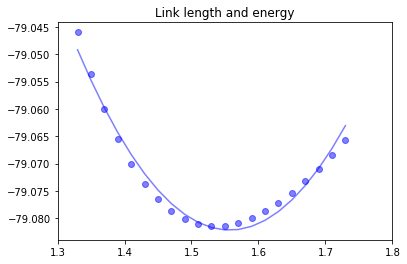

In [42]:
energy_dependency(link_lengths,energy_len, 'Link length and energy',1.3,1.8)

**Формируем массив 20 различных валентных углов в пределах от 109.2 до 113.2**

In [39]:
def inp_angle(angle):
    inp = '''!HF RHF 6-31G
    * int 0 1
    C 0 0 0 0 0 0 
    C 1 0 0 1.52986 0 0 
    H 1 2 0 1.08439 {0} 0
    H 1 2 3 1.08439 {0} 120
    H 1 2 3 1.08439 {0} -120
    H 2 1 3 1.08439 {0} 180
    H 2 1 5 1.08439 {0} 120
    H 2 1 5 1.08439 {0} -120
    *
    '''.format(angle)
    return inp

In [26]:
angles = np.arange(109.2,113.2,(113.2-109.2)/20)
print(angles)

[ 109.2  109.4  109.6  109.8  110.   110.2  110.4  110.6  110.8  111.
  111.2  111.4  111.6  111.8  112.   112.2  112.4  112.6  112.8  113. ]


In [27]:
len(angles)

20

In [29]:
energy_angles = list()

for i in angles:
    energy_angles.append(run_orca(inp_angle(i)))

print(energy_angles)

[-79.078791138209, -79.079183400066, -79.079549472821, -79.079889311529, -79.080202891616, -79.080490187722, -79.080751172795, -79.080985818069, -79.08119409307, -79.081375965653, -79.081531402161, -79.081660366819, -79.081762822554, -79.081838730525, -79.081888050195, -79.081910739351, -79.081906754045, -79.081876048815, -79.081818576377, -79.081734287686]


**Рисуем график зависимости энергии молекулы от валентного угла**

Optimized params: [  3.30816671e-04   1.12271983e+02  -7.90819114e+01]


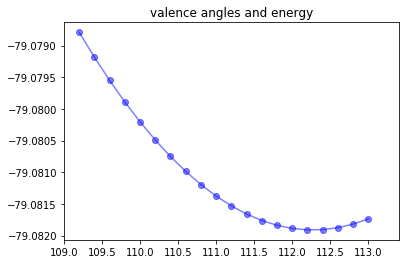

In [43]:
energy_dependency(angles,energy_angles, 'valence angles and energy',109,113.4)

Отличная аппроксимация, как и ожидалось (из лекции).

**Формируем массив различных торсионных углов в пределах от -180 до 180 с шагом 12**

In [65]:
def inp_torsion(torsion):
    torsion1 = torsion - 60.
    torsion2 = torsion + 60.
    inp = '''!HF RHF 6-31G
    * int 0 1
    C 0 0 0 0 0 0 
    C 1 0 0 1.52986 0 0 
    H 1 2 0 1.08439 111.200 0
    H 1 2 3 1.08439 111.200 120
    H 1 2 3 1.08439 111.200 -120
    H 2 1 3 1.08439 111.200 {0}
    H 2 1 5 1.08439 111.200 {1}
    H 2 1 5 1.08439 111.200 {2}
    *
    '''.format(torsion, torsion1, torsion2)
    return inp

In [54]:
torsions = np.arange(-180,192,12)
print(torsions)

[-180 -168 -156 -144 -132 -120 -108  -96  -84  -72  -60  -48  -36  -24  -12
    0   12   24   36   48   60   72   84   96  108  120  132  144  156  168
  180]


In [55]:
len(torsions)

31

In [66]:
energy_torsions = []

for i in torsions:
    energy_torsions.append(run_orca(inp_torsion(i)))

print(energy_torsions)

[-79.08153142935, -79.082613733245, -79.083665197014, -79.084283343101, -79.084235490395, -79.083542971541, -79.082468786938, -79.081419140127, -79.080793992197, -79.080835703972, -79.081531425731, -79.082613733261, -79.083665196902, -79.084283343103, -79.084235490374, -79.083542971544, -79.082468786883, -79.081419140194, -79.080793992237, -79.080835704057, -79.081531425784, -79.082613733277, -79.083665197014, -79.084283343103, -79.084235490391, -79.083542971545, -79.082468786931, -79.081419140068, -79.080793992183, -79.080835703989, -79.081531425729]


**Рисуем график зависимости энергии молекулы от валентного угла**

Optimized params: [  1.32752340e-08  -8.81800517e+01  -7.90827626e+01]


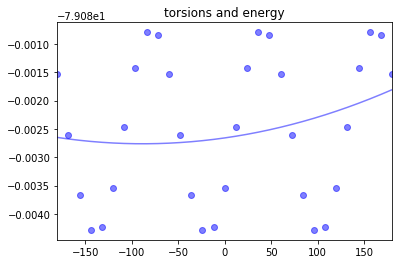

In [67]:
energy_dependency(torsions,energy_torsions, 'torsions and energy',-180,180)

Зафитим функцию через Фурье

Optimized params: [ -1.50760509e-03   9.94841116e-01  -7.90825389e+01  -1.00591817e-03
  -7.90110580e+01]


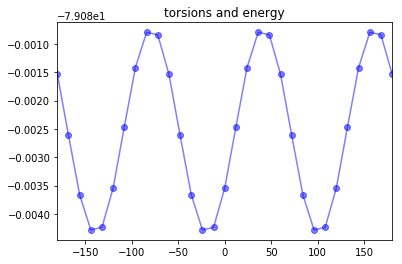

In [69]:
lim1 = -180
lim2 = 180
title = 'torsions and energy'


# fake x array , replace with real one
x_o=torsions
# fake y array, replace with energies
y_o=energy_torsions

#function is  f(x)=k(b-x)^2 + a
fitfunc = lambda p, x: p[0]*np.sin(p[1]*x)+p[3]*np.cos(p[4]*x) + p[2] # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Error function

p0 = [1,1,1,1, -79] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(x_o, y_o))
print "Optimized params:", p1

#Plot it
plt.plot(x_o, y_o, "ro", x_o,fitfunc(p1,x_o),"r-",c='blue',alpha=0.5)
plt.xlim(lim1,lim2)
plt.title(title)
plt.show()

**Увеличиваем шаг до 0.1 ангстрема**

In [72]:
link_lengths_2 = np.arange(-10,10)*0.1 + 1.52986
print (link_lengths_2)

[ 0.52986  0.62986  0.72986  0.82986  0.92986  1.02986  1.12986  1.22986
  1.32986  1.42986  1.52986  1.62986  1.72986  1.82986  1.92986  2.02986
  2.12986  2.22986  2.32986  2.42986]


In [73]:
len(link_lengths_2)

20

In [74]:
energy_len_2 = list()

for i in link_lengths_2:
    energy_len_2.append(run_orca(inp_len(i)))

print(energy_len_2)

[-73.376057904506, -75.600038674084, -76.986925190758, -77.840020402069, -78.364137030277, -78.683902686411, -78.875495245128, -78.986233920144, -79.045965568718, -79.07368949118, -79.081531419723, -79.077218664924, -79.065654757297, -79.049930677904, -79.031982697254, -79.013023521421, -78.993820247811, -78.974866462702, -78.956483580267, -78.938878296987]


Optimized params: [  2.95586926   1.75910803 -79.56411644]


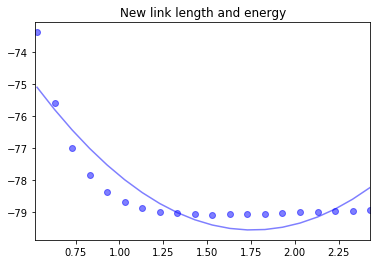

In [75]:
energy_dependency(link_lengths_2,energy_len_2, 'New link length and energy',0.52,2.43)

**Зафитим гиперболой:**

Optimized params: [-79.3302211    2.80503328]


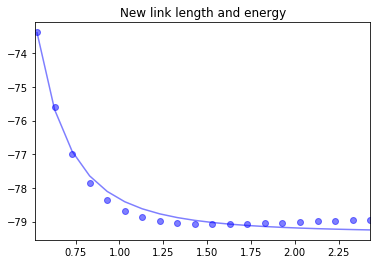

In [76]:
lim1 = 0.52
lim2 = 2.43
title = 'New link length and energy'

# fake x array , replace with real one
x_o=link_lengths_2
# fake y array, replace with energies
y_o=energy_len_2

fitfunc = lambda p, x: pow(1/x,p[1])+p[0] # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Error function

p0 = [1, -79] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(x_o, y_o))
print "Optimized params:", p1

#Plot it
plt.plot(x_o, y_o, "ro", x_o,fitfunc(p1,x_o),"r-",c='blue',alpha=0.5)
plt.xlim(lim1,lim2)
plt.title(title)
plt.show()